In [1]:
from google.colab import drive
drive.mount('/content/drive')

from urllib.request import urlopen
from PIL import Image
import torch
from transformers import AutoFeatureExtractor, ResNetForImageClassification, ResNetModel
import os
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import time
import numpy as np
device = 'cuda'
from transformers import ResNetModel
import torch

# Chemin du répertoire racine
import random
root_dir = '/content/drive/MyDrive/ColabNotebooks/mel'

# Dictionnaire pour stocker les images par sous-dossier
image_dict = {}

# Parcourir tous les sous-dossiers
for root, dirs, files in os.walk(root_dir):
    for file in files:
        # Construire le chemin complet du fichier
        file_path = os.path.join(root, file)

        # Vérifier si le fichier est une image en fonction de l'extension (par exemple, .png)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Ouvrir l'image avec Pillow
            image = Image.open(file_path)

            # Convertir l'image en format JPG (si elle n'est pas déjà en JPG)
            if image.format != "JPEG":
                image = image.convert("RGB")

            # Obtenez le nom du sous-dossier parent
            parent_dir = os.path.basename(os.path.dirname(file_path))

            # Vérifiez si le sous-dossier existe dans le dictionnaire, sinon créez-le
            if parent_dir not in image_dict:
                image_dict[parent_dir] = []

            # Ajouter l'image à la liste du sous-dossier correspondant
            image = image.resize((336,219))
            image_dict[parent_dir].append(np.array(image))

classical_list_MG = image_dict['classic']
non_classical_list_MG = image_dict['non_classic']

percent_classical_MG = int(0.2*len(classical_list_MG))
percent_non_classical_MG = int(0.2*len(non_classical_list_MG))


evaluation_list_dic = []
for sample in classical_list_MG[:percent_classical_MG]:
    buffer = []
    buffer.append(sample)
    buffer.append(0)
    evaluation_list_dic.append(buffer)

for sample in non_classical_list_MG[:percent_non_classical_MG]:
    buffer = []
    buffer.append(sample)
    buffer.append(1)
    evaluation_list_dic.append(buffer)

random.shuffle(evaluation_list_dic)
evaluation_list = []
for sample in evaluation_list_dic:
    evaluation_list.append(sample[0])

activeL_classical_list = classical_list_MG[percent_classical_MG:]
activeL_non_classical_list = non_classical_list_MG[percent_non_classical_MG:]

Mounted at /content/drive


Indices des échantillons sélectionnés : [82 18 65]
kmeans_label :  [0 1 0 0 0 0 1 2 2 2 2 1 0 0 2 2 0 2 1 2 2 1 1 0 2 1 0 0 0 2 1 2 0 0 0 2 2
 0 1 2 2 1 0 2 2 2 0 1 2 0 1 0 0 0 1 0 0 0 1 2 1 2 0 2 1 2 0 0 2 1 0 1 0 0
 2 0 0 2 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 2 0 2]


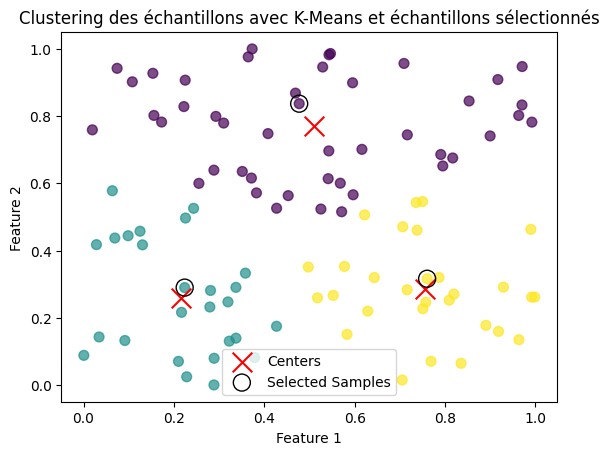

In [2]:
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# Charger votre dataset dans la variable X
# Remplacez cette ligne par le chargement réel de votre dataset
X = np.random.rand(100, 2)  # Exemple avec des données aléatoires

# Spécifier le nombre de clusters que vous souhaitez
n_clusters = 3

# Effectuer le clustering avec l'algorithme K-Means
kmeans = KMeans(n_clusters=n_clusters, n_init="auto")
kmeans.fit(X)

# Obtenir les centres des clusters
cluster_centers = kmeans.cluster_centers_

# Calculer les distances euclidiennes de chaque échantillon par rapport au centre de son cluster
distances = cdist(X, cluster_centers, 'euclidean')

# Sélectionner l'échantillon le plus proche de chaque centre de cluster
selected_samples = np.argmin(distances, axis=0)

# Afficher les indices des échantillons sélectionnés
print("Indices des échantillons sélectionnés :", selected_samples)
print("kmeans_label : ", kmeans.labels_)

# Tracer les échantillons avec des couleurs différentes pour chaque cluster
scatter = plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)

# Tracer les centres des clusters en rouge
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Centers')

# Tracer les échantillons sélectionnés avec un cercle autour
selected_samples_x = X[selected_samples, 0]
selected_samples_y = X[selected_samples, 1]
plt.scatter(selected_samples_x, selected_samples_y, facecolors='none', edgecolors='black', s=150, label='Selected Samples')

# Ajouter des légendes et des titres
plt.title('Clustering des échantillons avec K-Means et échantillons sélectionnés')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Afficher le graphe
plt.show()


In [3]:
from google.colab import drive
drive.mount('/content/drive')

from urllib.request import urlopen
from PIL import Image
import torch
from transformers import AutoFeatureExtractor, ResNetForImageClassification, ResNetModel
import os
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader
import time
import numpy as np
device = 'cuda'
from transformers import ResNetModel
import torch

def train(net, train_dataloader, criterion, optimizer, scheduler=None, epochs=100, device=device, checkpoint_epochs=2, timeout=45):
    start = time.time()
    print(f'Training for {epochs} epochs on {device}')

    for epoch in range(1,epochs+1):
        print(f"Epoch {epoch}/{epochs}")

        net.train()  # put network in train mode for Dropout and Batch Normalization
        train_loss = torch.tensor(0., device=device)  # loss and accuracy tensors are on the GPU to avoid data transfers
        train_accuracy = torch.tensor(0., device=device)
        for X, y in train_dataloader:
            X = X.to(device)
            y = y.type(torch.LongTensor).to(device)
            preds = net(X)
            loss = criterion(preds, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                train_loss += loss * train_dataloader.batch_size
                train_accuracy += (torch.argmax(preds, dim=1) == y).sum()

        if scheduler is not None:
            scheduler.step()

        print(f'Training loss: {train_loss/len(train_dataloader.dataset):.2f}')
        print(f'Training accuracy: {100*train_accuracy/len(train_dataloader.dataset):.2f}')


        if epoch%checkpoint_epochs==0:
            torch.save({
                'epoch': epoch,
                'state_dict': net.state_dict(),
                'optimizer': optimizer.state_dict(),
            }, './checkpoint.pth.tar')

        print()
        if((time.time() - start) >= timeout):
          break

    end = time.time()
    print(f'Total training time: {end-start:.1f} seconds')
    return net

# model definition
class Classifier_model(torch.nn.Module):
    # define model elements
    def __init__(self):
        super(Classifier_model, self).__init__()
        self.device = device
        self.image_processor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-18",device=self.device)
        self.pre_trained_model = ResNetModel.from_pretrained("microsoft/resnet-18")
        resnet18_output_size=25088
        self.fc = torch.nn.Linear(resnet18_output_size, 10)
        self.activation = torch.nn.ReLU()

    # forward propagate input
    def forward(self, X):
        X = self.image_processor(X, return_tensors="pt").to(self.device)
        # print(X.pixel_value.is_cuda)
        X = self.pre_trained_model(**X).last_hidden_state.flatten(start_dim=1)
        X = self.activation(X)
        X = self.fc(X)

        return X.softmax(dim=1)

    def features_extractor(self, X):
        X = self.image_processor(X, return_tensors="pt").to(self.device)
        # print(X.pixel_value.is_cuda)
        X = self.pre_trained_model(**X).last_hidden_state.flatten(start_dim=1)

        return X.softmax(dim=1)

# model definition
class Classifier_model_2(torch.nn.Module):
    # define model elements
    def __init__(self,f_model):
        super(Classifier_model_2, self).__init__()
        self.device = device
        resnet18_output_size=25088
        self.f_model = f_model
        self.fc = torch.nn.Linear(resnet18_output_size, 2)
        self.activation = torch.nn.ReLU()

    # forward propagate input
    def forward(self, X):
        #X = self.image_processor(X, return_tensors="pt").to(self.device)
        # print(X.pixel_value.is_cuda)
        X = self.f_model.features_extractor(X)
        X = self.activation(X)
        X = self.fc(X)

        return X.softmax(dim=1)


# Chemin du répertoire racine
import random
root_dir = '/content/drive/MyDrive/ColabNotebooks/mel'

# Dictionnaire pour stocker les images par sous-dossier
image_dict = {}

# Parcourir tous les sous-dossiers
for root, dirs, files in os.walk(root_dir):
    for file in files:
        # Construire le chemin complet du fichier
        file_path = os.path.join(root, file)

        # Vérifier si le fichier est une image en fonction de l'extension (par exemple, .png)
        if file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
            # Ouvrir l'image avec Pillow
            image = Image.open(file_path)

            # Convertir l'image en format JPG (si elle n'est pas déjà en JPG)
            if image.format != "JPEG":
                image = image.convert("RGB")

            # Obtenez le nom du sous-dossier parent
            parent_dir = os.path.basename(os.path.dirname(file_path))

            # Vérifiez si le sous-dossier existe dans le dictionnaire, sinon créez-le
            if parent_dir not in image_dict:
                image_dict[parent_dir] = []

            # Ajouter l'image à la liste du sous-dossier correspondant
            image = image.resize((336,219))
            image_dict[parent_dir].append(np.array(image))

classical_list_MG = image_dict['classic']
non_classical_list_MG = image_dict['non_classic']

percent_classical_MG = int(0.2*len(classical_list_MG))
percent_non_classical_MG = int(0.2*len(non_classical_list_MG))


evaluation_list_dic = []
for sample in classical_list_MG[:percent_classical_MG]:
    buffer = []
    buffer.append(sample)
    buffer.append(0)
    evaluation_list_dic.append(buffer)

for sample in non_classical_list_MG[:percent_non_classical_MG]:
    buffer = []
    buffer.append(sample)
    buffer.append(1)
    evaluation_list_dic.append(buffer)

random.shuffle(evaluation_list_dic)
evaluation_list = []
for sample in evaluation_list_dic:
    evaluation_list.append(sample[0])

activeL_classical_list = classical_list_MG[percent_classical_MG:]
activeL_non_classical_list = non_classical_list_MG[percent_non_classical_MG:]


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

def ClusterSampling(percent, previousPercent, model, dataset, strategy = "centroid"):

  # Calcul des prédictions
  # Calculer le nombre de clusters : n_clusters
  # Kmeans().fit(preds) -> retourne les différents clusters
  # En fonction de la stratégie sélectionnée, retourner une liste de samples différente.

  n_clusters = int((percent) * len(dataset))
  print("n_clusters", n_clusters)
  print("len dataset : ", len(dataset))

  with torch.no_grad():
    preds = model(dataset)

  preds_np = preds.numpy(force=True)

  kmeans = KMeans(n_clusters, n_init="auto").fit(preds_np)

  if(strategy == "centroid"):
    cluster_centers = kmeans.cluster_centers_
    distances = cdist(preds_np, cluster_centers, 'euclidean')
    selected_samples_index = np.argmin(distances, axis=0)
    selected_samples = dataset[selected_samples_index]
    dataset = np.delete(dataset, selected_samples_index, axis=0)


  elif(strategy == "outlier"):
    cluster_centers = kmeans.cluster_centers_
    distances = cdist(preds_np, cluster_centers, 'euclidean')
    selected_samples_index = np.zeros(n_clusters, dtype=int)

    for i in range(n_clusters):
      indices_cluster_i = np.where(kmeans.labels_ == i)[0]
      if((n_clusters != len(dataset)) or (len(indices_cluster_i) != 0)):
        index_farthest = indices_cluster_i[np.argmax(distances[indices_cluster_i, i])]
        selected_samples_index[i] = index_farthest

    if(n_clusters == len(dataset)):
      selected_samples = dataset
    else:
      selected_samples = dataset[selected_samples_index]
      if((len(indices_cluster_i) == 0)):
        print(f"NON PERTINENT")
      dataset = np.delete(dataset, selected_samples_index, axis=0)


  elif(strategy == "random"):
    cluster_centers = kmeans.cluster_centers_
    distances = cdist(preds_np, cluster_centers, 'euclidean')
    selected_samples_index = np.zeros(n_clusters, dtype=int)

    for i in range(n_clusters):
      indices_cluster_i = np.where(kmeans.labels_ == i)[0]
      if((n_clusters != len(dataset)) or (len(indices_cluster_i) != 0)):
        index_random = np.random.choice(indices_cluster_i)
        selected_samples_index[i] = index_random

    if(n_clusters == len(dataset)):
      selected_samples = dataset

    else:
      selected_samples = dataset[selected_samples_index]
      if((len(indices_cluster_i) == 0)):
        print(f"NON PERTINENT")
      dataset = np.delete(dataset, selected_samples_index, axis=0)


  scatter = plt.scatter(preds_np[:, 0], preds_np[:, 1], c=kmeans.labels_, cmap='viridis', s=50, alpha=0.7)

  plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Centers')

  selected_samples_x = preds_np[selected_samples_index, 0]
  selected_samples_y = preds_np[selected_samples_index, 1]
  plt.scatter(selected_samples_x, selected_samples_y, facecolors='none', edgecolors='black', s=150, label='Selected Samples')

  plt.title('Clustering des échantillons avec K-Means et échantillons sélectionnés')
  plt.xlabel('Feature 1')
  plt.ylabel('Feature 2')
  plt.legend()
  plt.ion()

  plt.show()

  return selected_samples, dataset

In [5]:
def ClusterDataLoader(selected_samples):

  # Now, we need to recreate two tensors knowing if each samples contained
  # inside the dataset is classical or not.
  new_active_classical = []
  new_active_non_classical = []

  for item in selected_samples:
      if any(np.array_equal(item, x) for x in activeL_classical_list):
          new_active_classical.append(item)
      else:
          new_active_non_classical.append(item)

  if (len(new_active_classical) == 0):
    tensor_x = torch.Tensor(new_active_non_classical).to(device)
    tensor_y = torch.Tensor(np.full(len(new_active_non_classical),  1)).to(device)

  else:
    tensor_x = torch.Tensor(np.concatenate((new_active_classical, new_active_non_classical), axis = 0)).to(device)
    tensor_y = torch.Tensor(np.concatenate((np.full(len(new_active_classical), 0),
                                        np.full(len(new_active_non_classical),  1)), axis=0)).to(device)

  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  my_dataloader = DataLoader(my_dataset,batch_size=10, shuffle=True)
  return my_dataloader

In [23]:
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def clusterConfidence_Train(modelToTrain, evaluation_list,save_dir='/content/drive/MyDrive/ColabNotebooks/models/Cluster', strategy = "centroid"):

    # Créer un répertoire s'il n'existe pas pour y stocker les modèles
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if not os.path.exists(f"{save_dir}/{strategy}"):
      os.makedirs(f"{save_dir}/{strategy}")

    results = []

    # Pourcentages du dataset à sélectionner
    percentages = [0.02, 0.05,0.10, 0.20, 0.50, 0.70, 1.00]
    previousPercent = 0

    dataset = np.concatenate((activeL_classical_list, activeL_non_classical_list))
    print(len(dataset))
    for percent in percentages:
        print(f"""
        #############################
        #         NEW ROUND         #
        #     percent = {percent}   #
        #############################
        """)
        lr, weight_decay, epochs,timeout = 1e-5, 5e-4, 1000, 30
        net = torch.load(modelToTrain)
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(),lr=lr, weight_decay=weight_decay)

        # Active Learning
        print(f"""
        #############################
        #    Calculating Cluster    #
        #############################
        """)
        samples_to_take, dataset = ClusterSampling(percent, previousPercent, net, dataset, strategy)
        dataloader = ClusterDataLoader(samples_to_take)

        print(f"""
        #############################
        #       Begin Training      #
        #############################
        """)

        net2 = train(net, dataloader, loss, optimizer, None, epochs, device, timeout=timeout)
        torch.save(net2, save_dir + "/" + strategy + "/" + strategy + str(percent) + "_percent.pt")



        # Faire des prédictions sur la liste d'évaluation
        model = net2
        model.eval()
        test_data=torch.Tensor(np.array(evaluation_list)).to(device)
        with torch.no_grad():
          preds = model(test_data)
        output=torch.argmax(preds, dim=1)

        # Evaluation du modèle
        count = 0
        for i in range(0,len(output)):
            if output[i].item() == evaluation_list_dic[i][1]:
                count+=1
        print(f"Cluster " + strategy + f" {percent} % accuracy :{(count/len(output))*100}) + %")
        print(output)

        accuracy = (count/len(output))*100, epochs

        # Ajouter les résultats à la liste
        results.append([percent, accuracy])
        previousPercent = percent
        # Utiliser le modèle précédent pour poursuivre l'entraînement
        modelToTrain = save_dir + "/" + strategy + "/" + strategy + str(percent) + "_percent.pt"

    # Créer un DataFrame à partir des résultats
    results_df = pd.DataFrame(results, columns=['Percentage', 'Accuracy'])

    # Sauvegarder les résultats dans un fichier CSV
    results_csv_path = os.path.join(save_dir + "/" + strategy, 'results.csv')
    results_df.to_csv(results_csv_path, index=False)

    return results_df


1379

        #############################
        #         NEW ROUND         #
        #     percent = 0.02   #
        #############################
        

        #############################
        #    Calculating Cluster    #
        #############################
        
n_clusters 27
len dataset :  1379


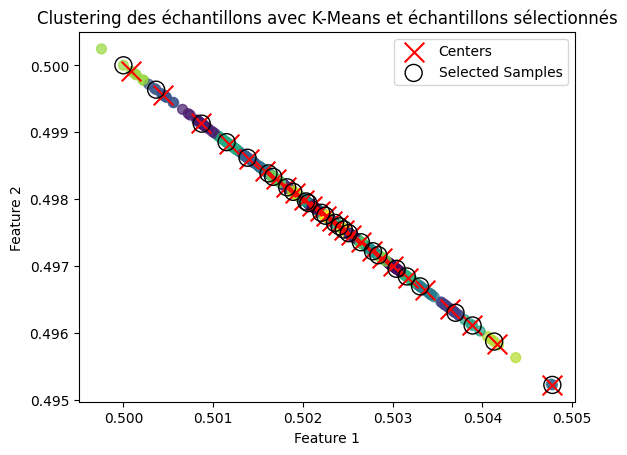


        #############################
        #       Begin Training      #
        #############################
        
Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 0.77
Training accuracy: 40.74

Epoch 2/1000
Training loss: 0.77
Training accuracy: 40.74

Epoch 3/1000
Training loss: 0.77
Training accuracy: 40.74

Epoch 4/1000
Training loss: 0.77
Training accuracy: 40.74

Epoch 5/1000
Training loss: 0.77
Training accuracy: 40.74

Epoch 6/1000
Training loss: 0.77
Training accuracy: 44.44

Epoch 7/1000
Training loss: 0.77
Training accuracy: 44.44

Epoch 8/1000
Training loss: 0.77
Training accuracy: 44.44

Epoch 9/1000
Training loss: 0.77
Training accuracy: 44.44

Epoch 10/1000
Training loss: 0.77
Training accuracy: 48.15

Epoch 11/1000
Training loss: 0.77
Training accuracy: 48.15

Epoch 12/1000
Training loss: 0.77
Training accuracy: 48.15

Epoch 13/1000
Training loss: 0.77
Training accuracy: 48.15

Epoch 14/1000
Training loss: 0.77
Training accuracy: 55.56

Epoch 15/100

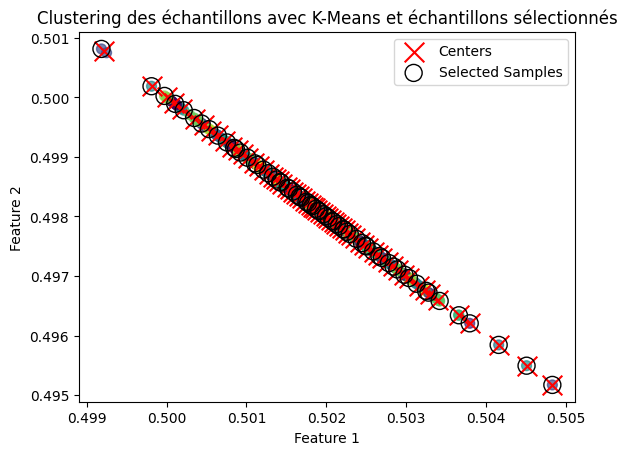


        #############################
        #       Begin Training      #
        #############################
        
Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 0.73
Training accuracy: 23.88

Epoch 2/1000
Training loss: 0.72
Training accuracy: 25.37

Epoch 3/1000
Training loss: 0.72
Training accuracy: 28.36

Epoch 4/1000
Training loss: 0.72
Training accuracy: 29.85

Epoch 5/1000
Training loss: 0.72
Training accuracy: 28.36

Epoch 6/1000
Training loss: 0.72
Training accuracy: 31.34

Epoch 7/1000
Training loss: 0.72
Training accuracy: 38.81

Epoch 8/1000
Training loss: 0.72
Training accuracy: 35.82

Epoch 9/1000
Training loss: 0.72
Training accuracy: 41.79

Epoch 10/1000
Training loss: 0.72
Training accuracy: 41.79

Epoch 11/1000
Training loss: 0.72
Training accuracy: 49.25

Epoch 12/1000
Training loss: 0.72
Training accuracy: 53.73

Epoch 13/1000
Training loss: 0.72
Training accuracy: 64.18

Epoch 14/1000
Training loss: 0.72
Training accuracy: 65.67

Epoch 15/100

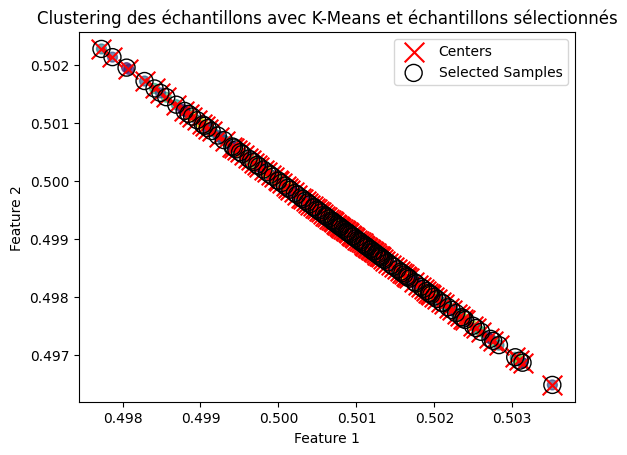


        #############################
        #       Begin Training      #
        #############################
        
Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 0.70
Training accuracy: 33.59

Epoch 2/1000
Training loss: 0.70
Training accuracy: 38.28

Epoch 3/1000
Training loss: 0.70
Training accuracy: 49.22

Epoch 4/1000
Training loss: 0.70
Training accuracy: 50.00

Epoch 5/1000
Training loss: 0.70
Training accuracy: 65.62

Epoch 6/1000
Training loss: 0.70
Training accuracy: 70.31

Epoch 7/1000
Training loss: 0.70
Training accuracy: 78.91

Epoch 8/1000
Training loss: 0.70
Training accuracy: 85.94

Epoch 9/1000
Training loss: 0.70
Training accuracy: 88.28

Epoch 10/1000
Training loss: 0.70
Training accuracy: 96.09

Epoch 11/1000
Training loss: 0.70
Training accuracy: 94.53

Epoch 12/1000
Training loss: 0.70
Training accuracy: 96.09

Epoch 13/1000
Training loss: 0.70
Training accuracy: 97.66

Epoch 14/1000
Training loss: 0.70
Training accuracy: 98.44

Total traini

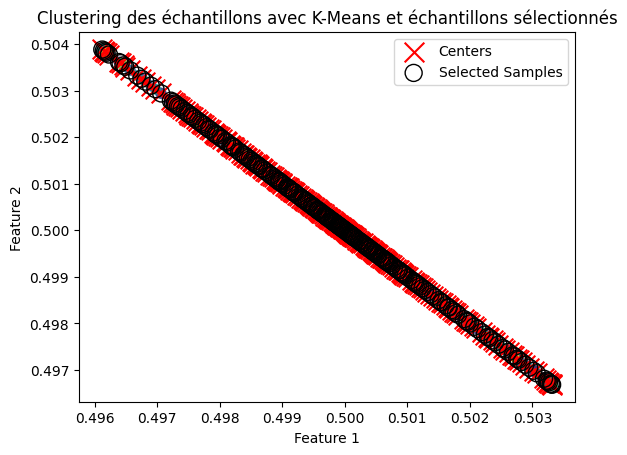


        #############################
        #       Begin Training      #
        #############################
        
Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 0.72
Training accuracy: 86.58

Epoch 2/1000
Training loss: 0.72
Training accuracy: 93.94

Epoch 3/1000
Training loss: 0.72
Training accuracy: 93.94

Epoch 4/1000
Training loss: 0.72
Training accuracy: 95.67

Epoch 5/1000
Training loss: 0.72
Training accuracy: 96.97

Epoch 6/1000
Training loss: 0.72
Training accuracy: 96.97

Epoch 7/1000
Training loss: 0.72
Training accuracy: 97.40

Epoch 8/1000
Training loss: 0.72
Training accuracy: 96.10

Total training time: 30.3 seconds
Cluster random 0.2 % accuracy :86.33720930232558) + %
tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

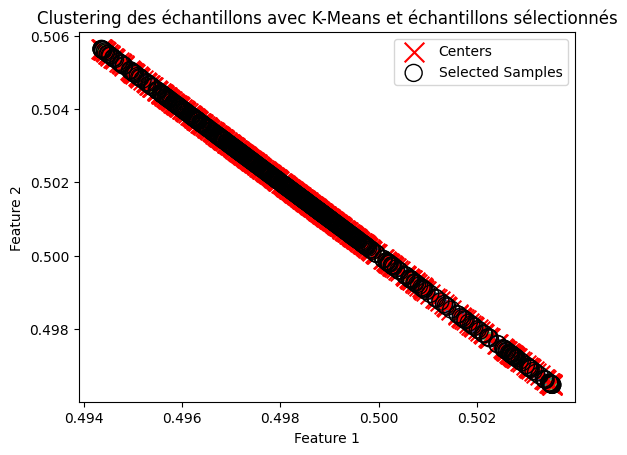


        #############################
        #       Begin Training      #
        #############################
        
Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 0.70
Training accuracy: 89.63

Epoch 2/1000
Training loss: 0.70
Training accuracy: 93.95

Epoch 3/1000
Training loss: 0.70
Training accuracy: 94.17

Epoch 4/1000
Training loss: 0.70
Training accuracy: 94.60

Epoch 5/1000
Training loss: 0.70
Training accuracy: 97.62

Total training time: 35.8 seconds
Cluster random 0.5 % accuracy :92.15116279069767) + %
tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1

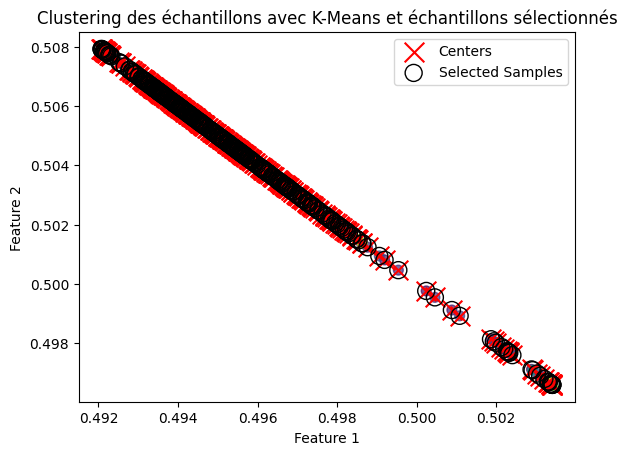


        #############################
        #       Begin Training      #
        #############################
        
Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 0.70
Training accuracy: 92.90

Epoch 2/1000
Training loss: 0.70
Training accuracy: 94.14

Epoch 3/1000
Training loss: 0.70
Training accuracy: 96.30

Epoch 4/1000
Training loss: 0.70
Training accuracy: 95.99

Epoch 5/1000
Training loss: 0.70
Training accuracy: 96.91

Total training time: 30.2 seconds
Cluster random 0.7 % accuracy :93.6046511627907) + %
tensor([0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,

<ipython-input-25-c673c16fec5f>:21: ConvergenceWarning: Number of distinct clusters (124) found smaller than n_clusters (139). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters, n_init="auto").fit(preds_np)


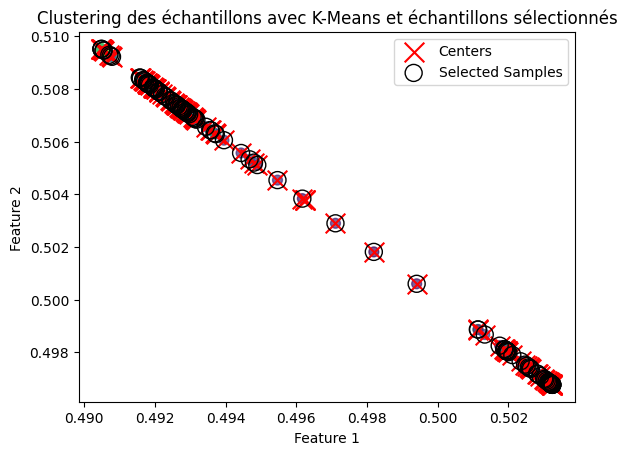


        #############################
        #       Begin Training      #
        #############################
        
Training for 1000 epochs on cuda
Epoch 1/1000
Training loss: 0.69
Training accuracy: 93.53

Epoch 2/1000
Training loss: 0.69
Training accuracy: 96.40

Epoch 3/1000
Training loss: 0.69
Training accuracy: 92.09

Epoch 4/1000
Training loss: 0.69
Training accuracy: 100.00

Epoch 5/1000
Training loss: 0.69
Training accuracy: 99.28

Epoch 6/1000
Training loss: 0.69
Training accuracy: 97.12

Epoch 7/1000
Training loss: 0.69
Training accuracy: 99.28

Epoch 8/1000
Training loss: 0.69
Training accuracy: 100.00

Epoch 9/1000
Training loss: 0.69
Training accuracy: 98.56

Epoch 10/1000
Training loss: 0.69
Training accuracy: 99.28

Epoch 11/1000
Training loss: 0.69
Training accuracy: 97.84

Epoch 12/1000
Training loss: 0.69
Training accuracy: 99.28

Epoch 13/1000
Training loss: 0.69
Training accuracy: 100.00

Total training time: 30.2 seconds
Cluster random 1.0 % accuracy :93.0

,Percentage,Accuracy
0,0.02,"(24.418604651162788, 1000)"
1,0.05,"(29.360465116279073, 1000)"
2,0.10,"(70.63953488372093, 1000)"
3,0.20,"(86.33720930232558, 1000)"
4,0.50,"(92.15116279069767, 1000)"
5,0.70,"(93.6046511627907, 1000)"
6,1.00,"(93.02325581395348, 1000)"


In [28]:
clusterConfidence_Train("/content/drive/MyDrive/ColabNotebooks/model_2_Clem_trainings_longEgale_Colab.pt", evaluation_list, strategy="random")

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


def printGraph(strategy = "random", multiple_times = False, save = False):

  if (multiple_times == False):

    if(strategy == "random"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/randomPicking/results.csv'
      ]
    if(strategy == "ratio"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/RatioOfConfidence/results.csv'
      ]
    if(strategy == "margin"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/MarginOfConfidence/results.csv'
      ]
    if(strategy == "least"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/LeastConfidence/results.csv'
      ]
    if(strategy == "entropy"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/EntropyConfidence/results.csv'
      ]
    if(strategy == "cluster_random"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/Cluster/random/results.csv'
      ]
    if(strategy == "cluster_centroid"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/Cluster/centroid/results.csv'
      ]
    if(strategy == "cluster_outlier"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/Cluster/outlier/results.csv'
      ]


  elif(multiple_times == True):
    if(strategy == "random"):
      chemins_fichiers_csv = [
        '/content/drive/MyDrive/ColabNotebooks/models/randomPicking/0/results_0.csv',
        '/content/drive/MyDrive/ColabNotebooks/models/randomPicking/1/results_1.csv',
        '/content/drive/MyDrive/ColabNotebooks/models/randomPicking/2/results_2.csv'
      ]

  donnees_liste = [pd.read_csv(chemin) for chemin in chemins_fichiers_csv]
  # Supprimer les parenthèses et convertir la colonne Accuracy en flottant pour chaque fichier
  for donnees in donnees_liste:
      donnees['Accuracy'] = donnees['Accuracy'].apply(lambda x: float(x.strip('()').split(',')[0]))

  # Concaténer les données en une seule DataFrame
  donnees_concat = pd.concat(donnees_liste)

  # Calculer la moyenne, le maximum et le minimum pour chaque point
  moyenne_donnees = donnees_concat.groupby('Percentage').mean()
  # print(moyenne_donnees)
  lower_error = donnees_concat.groupby('Percentage').min()
  upper_error = donnees_concat.groupby('Percentage').max()

  # Calculer l'incertitude comme la moitié de la différence entre le maximum et le minimum
  incertitude = [lower_error['Accuracy']/moyenne_donnees['Accuracy'], upper_error['Accuracy']/moyenne_donnees['Accuracy']]

  # Tracer le graphique avec des barres d'erreur pour tous les points
  if(multiple_times == True):
    plt.errorbar(moyenne_donnees.index, moyenne_donnees['Accuracy'], yerr=incertitude, fmt='-', label='Moyenne avec incertitude', ecolor='red')
  else:
    plt.plot(donnees['Percentage'], donnees['Accuracy'])
    plt.scatter(donnees['Percentage'], donnees['Accuracy'])

  plt.xlabel('Percentage')
  plt.ylabel('Accuracy')
  if(multiple_times == False):
    plt.title(f"Performance des modèles - stratégie : {strategy}")
  else:
    plt.title(f"Performance moyenne  des modèles - stratégie : {strategy}")
  plt.legend()
  if (save==True):
    plt.savefig(f"/content/drive/MyDrive/ColabNotebooks/models/graphs/{strategy}.png")
  plt.show()


  return

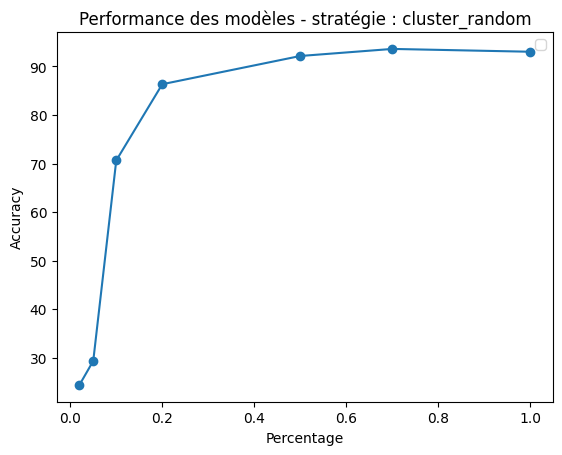

In [30]:
printGraph(strategy = "cluster_random", multiple_times = False, save = True)